In [7]:
# IMPORT
# Standard libray
import sys, os
from importlib import reload
sys.path.append("..")

# Common library
from tqdm import tqdm
import numpy as np
import scipy
from pylab import *
import scipy.interpolate

# ROOT>....
import ROOT
# Make global style changes
ROOT.gStyle.SetOptStat(0) # Disable the statistics box
ROOT.gStyle.SetTextFont(42)
# ROOT.gStyle.SetOptFit(1111)
import atlasplots as aplt
aplt.set_atlas_style()
ROOT.gStyle.SetTitleXOffset(1)
ROOT.gStyle.SetTitleYOffset(1.8)

# Custom helper functions
import MuHelper.muhelper.helper_basic as hp
import helper_tofpet as hptof

# ROOT.gStyle.SetPalette(len(hptof.mpl_colors), hptof.mpl_colors32)
ROOT.gStyle.SetPalette(ROOT.kViridis)
# colors=[int(c) for c in hptof.mpl_colors ]
colors=hptof.mpl_colors_cls()

Applying ATLAS style settings


In [8]:
working_dir = "/mnt/sda2/tofpet_data/test_stand_init/"
filename = working_dir+"processed/"+  "full_cosmic_2_coinc_processed.root"


coinc_pairs = np.loadtxt("../configurations/coinc_pairs.csv", delimiter=",", dtype=int)
coinc_pairs = {(a[0], a[1]):a[2] for a in coinc_pairs}


# Open root file

In [9]:
tfile = ROOT.TFile.Open(filename)

tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
entries = Tree.GetEntries()

print("Tree name:", tree_name)
print("Branches:", branches)
print("Entries:", entries)



# Use dataframe to quickly get things into numpy
df = ROOT.RDataFrame(tree_name, filename)
# df = df.Define('dt', '0.5*(time1-time2)')

# cut_energy = "hit_nrg1>20 && hit_nrg2>20"
# data = df.Filter(cut_energy).AsNumpy()
data = df.AsNumpy()



Tree name: mapped
Branches: ['hit_x', 'hit_y', 'hit_z', 'hit_t', 'hit_x_err', 'hit_y_err', 'hit_z_err', 'hit_t_err', 'hit_ass', 'hit_det_id', 'hit_ch_id', 'hit_pair_id', 'hit_nrg1', 'hit_nrg2']
Entries: 3318467


Text(0.5, 0, 'z [cm]')

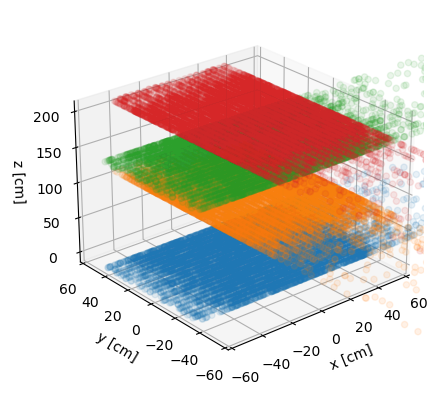

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)

n_plot=9000
for layer in range(1,5):
    mask = data["hit_ass"]==layer
    ax.scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot], data["hit_z"][mask][:n_plot], alpha=0.1, zorder=layer)

ax.view_init(elev=25, azim=230)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")

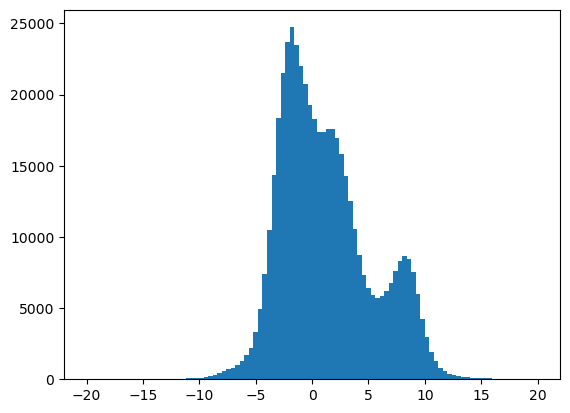

In [11]:
hist(np.diff(data["hit_t"]),bins=100, range=(-20,20));

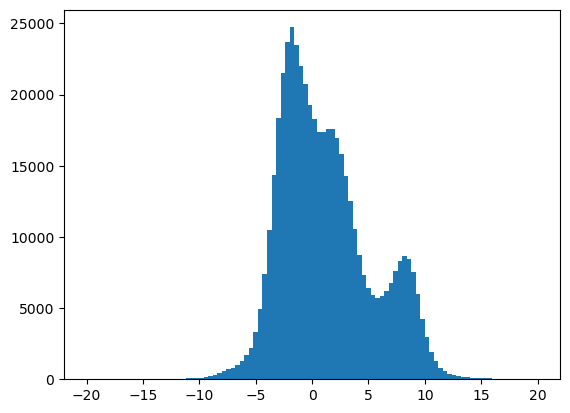

In [12]:
hist(np.diff(data["hit_t"]),bins=100, range=(-20,20));

ndarray(177692)

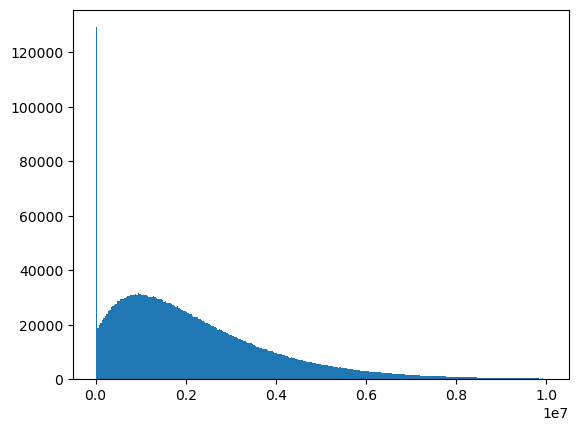

In [13]:
# Sort everything by time, with energy cut
inds_sort = np.argsort(data["hit_t"])
for key in data:
    data[key]=data[key]

hist(data["hit_t"][2:]-data["hit_t"][:-2], bins=300, range=(0,10000000));

sum((data["hit_t"][2:]-data["hit_t"][:-2])<50)

In [14]:
events={key:[] for key in branches}

N_HIT_MIN=3
WINDOW=50 #ns

event_found=False
i=0
while i<(len(data["hit_x"])-N_HIT_MIN):
    if data["hit_t"][i+N_HIT_MIN-1]-data["hit_t"][i] <WINDOW:
        last_hit_ind = N_HIT_MIN-1
        # Find the last hit that is still within the time window
        for j in range(N_HIT_MIN, len(data["hit_x"])-N_HIT_MIN-i):
            if (data["hit_t"][i+j]-data["hit_t"][i])<WINDOW:
                last_hit_ind=j
            else:
                break

        # Record all hits within the window
        # if len(np.unique(data["hit_z"][i:i+last_hit_ind+1]))==last_hit_ind+1:
        #     for key in events:
        #         events[key].append(data[key][i:i+last_hit_ind+1])
        #     # Update i
        #     i+=last_hit_ind
        # else:
        #     i+=1


        for key in events:
            events[key].append(data[key][i:i+last_hit_ind+1])
        # Update i
        i+=last_hit_ind
    else:
        i+=1

for key in events:
    events[key]=np.array(events[key], dtype=object)

print(len(events["hit_x"]), "events found")


118435 events found


[7.7823e+04 3.0999e+04 5.7710e+03 1.9550e+03 8.6700e+02 4.1600e+02
 2.1000e+02 1.1500e+02 8.0000e+01 7.3000e+01]


Text(0, 0.5, 'Counts')

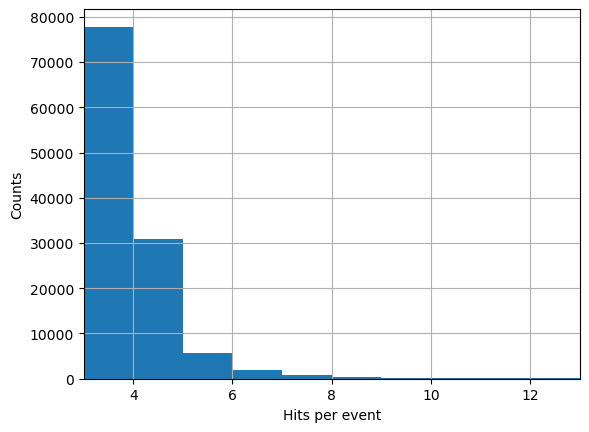

In [15]:
lengths = np.array([len(i) for i in events["hit_x"]])
nbins=10
n,ibins, p = hist(lengths,bins=nbins, range=(3,3+nbins));
print(n)
xlim(3,3+nbins)
grid()
xlabel("Hits per event")
ylabel("Counts")

# estimated_rate_4hits = 80**2/60 * (0.8**2)/(2*3.141*1**2) *3600
# axhline(estimated_rate_4hits)

Text(0.5, 0, 'z [cm]')

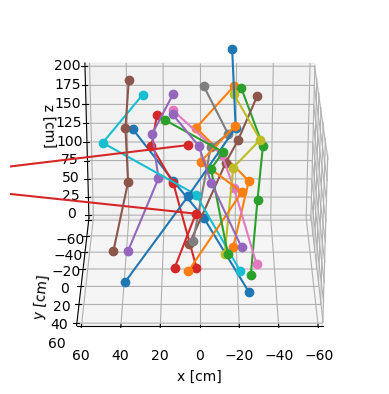

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)

nhit=4
mask_nhit = (lengths==nhit)
for ievent in range(50,70):
    x,y,z,t = events["hit_x"][mask_nhit][ievent], events["hit_y"][mask_nhit][ievent], events["hit_z"][mask_nhit][ievent], events["hit_t"][mask_nhit][ievent]
    if len(np.unique(z))!=nhit:
        continue

    inds = np.argsort(z)
    x,y,z,t = x[inds],y[inds],z[inds],t[inds]
    ax.plot(x,y,z, alpha=1, zorder=ievent, linestyle="-", marker="o")


ax.view_init(elev=25, azim=90)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")

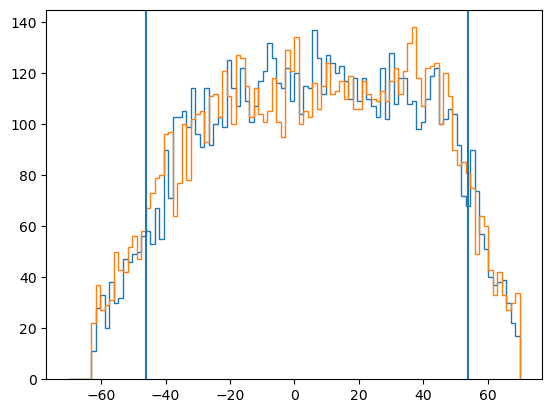

In [28]:
layer=1
mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==295)
hist(data["hit_x"][mask][:n_plot], bins=100, range=[-70,70], histtype="step");

layer=3
mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==335)
hist(data["hit_x"][mask][:n_plot], bins=100, range=[-70,70], histtype="step");
axvline(-46)
axvline(100-46)

In [18]:
# layer=3
# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==77)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])
        
# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==66)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])

# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==125)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])

# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==123)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])